In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import chardet
import glob
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import sys
import cfunits

# import custom modules
sys.path.append('../scripts')
import funcs

/opt/homebrew/anaconda3/envs/leaf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>
NOTE: If certain fancy characters aren't used in a file, an encoder will pick it up as us/ascii even if I've explicitly encoded it as utf-8-sig, and that's fine. UTF-8-SIG just ensures that the .csv is read properly in Excel on a Mac AND a windows computer.

In [2]:
filename = 'smith_2017'
data_dir_path = f'../data/input/{filename}/LCE_ACi_curves'

In [3]:
# # ensure encoding of individual ACI curve files
# for filename in os.listdir(data_dir_path):
#     if filename.endswith(".csv"):
#         original_file_path = os.path.join(data_dir_path, filename)
#         funcs.convert_to_utf8sig(original_file_path)

In [4]:
# concatenate ACI curve files into one parent file
output_file = f'../data/input/{filename}/LCE_ACi_curves.csv'
dataframes = []
for f in os.listdir(data_dir_path):
    if f.endswith("_utf8sig.csv"):
        file_path = os.path.join(data_dir_path, f)
        df = pd.read_csv(file_path)
        dataframes.append(df)

concatenated_df = pd.concat(dataframes, ignore_index=True)
concatenated_df.to_csv(output_file, index=False, encoding='utf-8-sig')

In [5]:
# ensure readable encoding of summary data (01) and raw curve data (02)
data_path_01 = f'../data/input/{filename}/LCE_data.csv'
utf8_data_path_01 = funcs.convert_to_utf8sig(data_path_01)
data_path_02 = f'../data/input/{filename}/LCE_ACi_curves.csv'
utf8_data_path_02 = funcs.convert_to_utf8sig(data_path_02)

# ensure readable encoding of metadata files (01, 02)
metadata_path_01 = f'../data/input/{filename}/LCE_dictionary.csv'
utf8_metadata_path_01 = funcs.convert_to_utf8sig(metadata_path_01)
metadata_path_02 = f'../data/input/{filename}/LCE_ACi_dictionary.csv'
utf8_metadata_path_02 = funcs.convert_to_utf8sig(metadata_path_02)

Encoding ascii was detected for ../data/input/smith_2017/LCE_data.csv.
Converted ../data/input/smith_2017/LCE_data.csv to utf-8-sig and saved as ../data/input/smith_2017/LCE_data_utf8sig.csv
Encoding UTF-8-SIG was detected for ../data/input/smith_2017/LCE_ACi_curves.csv.
../data/input/smith_2017/LCE_ACi_curves.csv is already in utf-8-sig encoding.
Encoding utf-8 was detected for ../data/input/smith_2017/LCE_dictionary.csv.
Converted ../data/input/smith_2017/LCE_dictionary.csv to utf-8-sig and saved as ../data/input/smith_2017/LCE_dictionary_utf8sig.csv
Encoding utf-8 was detected for ../data/input/smith_2017/LCE_ACi_dictionary.csv.
Converted ../data/input/smith_2017/LCE_ACi_dictionary.csv to utf-8-sig and saved as ../data/input/smith_2017/LCE_ACi_dictionary_utf8sig.csv


In [6]:
# read the data
d1 = pd.read_csv(utf8_data_path_01)
d1 = d1.drop(columns=[col for col in d1.columns if 'Tavg' in col])
d2 = pd.read_csv(utf8_data_path_02)
data = pd.merge(left=d2, right=d1, left_on='id', right_on='aci_id', how='left', suffixes=(None, '_y'))
data = data.drop(columns=['Unnamed: 0', 'Cond_y', 'LA_y'])

# read the metadata
m1 = pd.read_csv(utf8_metadata_path_01)
m2 = pd.read_csv(utf8_metadata_path_02)
metadata = pd.concat([m1, m2])

In [7]:
# # Create the profiling report
# profile = ProfileReport(data, title=f"{filename} Profiling Report")

# # Save the profile report as HTML
# output_directory = f'../data/input/{filename}'
# report_html_path = os.path.join(output_directory, f"{filename}_report.html")
# profile.to_file(report_html_path)
# print(f"Profiling report saved as {report_html_path}")

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [8]:
data.columns

Index(['Photo', 'Cond', 'Ci', 'Trmmol', 'VPD', 'LA', 'StmRat', 'BLCond',
       'Tair', 'Tleaf', 'TBlk', 'CO2R', 'CO2S', 'H2OR', 'H2OS', 'RH_R', 'RH_S',
       'Flow', 'Pari', 'Press', 'id', 'X', 'SetLA', 'index', 'Date', 'Year',
       'Day', 'Location', 'Lat', 'Lon', 'Genus', 'Species', 'Rep', 'Phenology',
       'Lifespan', 'Photosynthesis', 'Stature', 'Juvenile', 'Vcmax', 'Jmax',
       'Vpmax', 'Rd', 'Tleaf_photo', 'Tleaf_R', 'LM', 'CN', 'Nper', 'Cper',
       'LWP_MPa', 'DBH', 'Height', 'SMper', 'FCper', 'Satper', 'ai',
       'Temperature_gs', 'Precipitation_gs', 'VPD_gs', 'PAR_gs', 'aci_id',
       'leaf_shape'],
      dtype='object')

In [9]:
# this is how the metadata file should be structured before reading it: variable, description, units
# this may have to be created or edited manually before reading it here
metadata = metadata.rename(columns={'Variable':'variable', 'Units':'unit', 'Description':'description'})
metadata

,variable,unit,description
0,index,unitless,Unique number for indexing
1,Date,mm/dd/yy,Date of measurement
2,Year,unitless,Year of measurement
3,Day,unitless,Day of year of measurement
4,Location,unitless,Location of measurement
...,...,...,...
16,RH_S,%,Sample relative humidity
17,Flow,µmol/s,Flow rate
18,Pari,µmol/m2/s,Photosynthetically active radiation inside the...
19,Press,kPa,Atmospheric pressure


---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [10]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

   variable unit description
23        X  NaN         NaN
24    SetLA  NaN         NaN


In [11]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['variable'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

In [12]:
# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()
data

variable                      Photo                                    Cond  \
description Net photosynthetic rate Mean stomatal conductance for Aci curve   
unit                      µmol/m2/s                             mol m-2 s-1   
4                              1.01                                  0.0257   
5                            0.0409                                  0.0273   
6                            -0.421                                  0.0284   
7                              3.46                                  0.0302   
8                              3.44                                  0.0311   
...                             ...                                     ...   
7572                           24.9                                   0.414   
7573                           25.4                                   0.406   
7574                           26.7                                   0.417   
7575                           27.3                                   0.411   
7576                           28.6                                   0.414   

variable                                        Ci             Trmmol  \
description Stomatal conductance Intracellular CO2 Transpiration rate   
unit                    mol/m2/s          µmol/mol          mmol/m2/s   
4                         0.0257             132.0              0.371   
5                         0.0273              95.2               0.39   
6                         0.0284              74.2              0.401   
7                         0.0302             202.0              0.423   
8                         0.0311             206.0              0.433   
...                          ...               ...                ...   
7572                       0.414             622.0                3.7   
7573                       0.406             810.0               3.63   
7574                       0.417            1000.0                3.7   
7575                       0.411            1290.0               3.65   
7576                       0.414            1770.0               3.66   

variable                       VPD        LA       \
description Vapor pressure deifcit Leaf area        
unit                           kPa       cm2  cm2   
4                             1.42       6.0  6.0   
5                             1.41       6.0  6.0   
6                              1.4       6.0  6.0   
7                             1.38       6.0  6.0   
8                             1.38       6.0  6.0   
...                            ...       ...  ...   
7572                         0.996       6.0  6.0   
7573                         0.995       6.0  6.0   
7574                         0.993       6.0  6.0   
7575                         0.989       6.0  6.0   
7576                         0.987       6.0  6.0   

variable                                                      StmRat  \
description Ratio of stomatal density from one sideo f leaf to other   
unit                                                             NaN   
4                                                          0.5         
5                                                          0.5         
6                                                          0.5         
7                                                          0.5         
8                                                          0.5         
...                                                        ...         
7572                                                       0.5         
7573                                                       0.5         
7574                                                       0.5         
7575                                                       0.5         
7576                                                       0.5         

variable                        BLCond  ...  \
description Boundary layer conductance  ...   
unit                    

---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [13]:
data.columns.get_level_values(0)

Index(['Photo', 'Cond', 'Cond', 'Ci', 'Trmmol', 'VPD', 'LA', 'LA', 'StmRat',
       'BLCond', 'Tair', 'Tleaf', 'TBlk', 'CO2R', 'CO2S', 'H2OR', 'H2OS',
       'RH_R', 'RH_S', 'Flow', 'Pari', 'Press', 'id', 'X', 'SetLA', 'index',
       'Date', 'Year', 'Day', 'Location', 'Lat', 'Lon', 'Genus', 'Species',
       'Rep', 'Phenology', 'Lifespan', 'Photosynthesis', 'Stature', 'Juvenile',
       'Vcmax', 'Jmax', 'Vpmax', 'Rd', 'Tleaf_photo', 'Tleaf_R', 'LM', 'CN',
       'Nper', 'Cper', 'LWP_MPa', 'DBH', 'Height', 'SMper', 'FCper', 'Satper',
       'ai', 'Temperature_gs', 'Precipitation_gs', 'VPD_gs', 'PAR_gs',
       'aci_id', 'leaf_shape'],
      dtype='object', name='variable')

In [14]:
data.columns.get_level_values(1)

Index([                                                                                                                         'Net photosynthetic rate',
                                                                                                                'Mean stomatal conductance for Aci curve',
                                                                                                                                   'Stomatal conductance',
                                                                                                                                      'Intracellular CO2',
                                                                                                                                     'Transpiration rate',
                                                                                                                                 'Vapor pressure deifcit',
                                                                      

In [15]:
data.columns.get_level_values(2)

Index([  'µmol/m2/s', 'mol m-2 s-1',    'mol/m2/s',    'µmol/mol',
         'mmol/m2/s',         'kPa',         'cm2',         'cm2',
                 nan,    'mol/m2/s',          '°C',          '°C',
                '°C',    'µmol/mol',    'µmol/mol',    'mmol/mol',
          'mmol/mol',           '%',           '%',      'µmol/s',
         'µmol/m2/s',         'kPa',           nan,           nan,
                 nan,    'unitless',    'mm/dd/yy',    'unitless',
          'unitless',    'unitless',           '¡',           '¡',
          'unitless',    'unitless',    'unitless',    'unitless',
          'unitless',    'unitless',    'unitless',    'unitless',
         'µmol/m2/s',   'µmol/m2/s',   'µmol/m2/s',   'µmol/m2/s',
                '¡C',          '¡C',           'g',         'g/g',
                 '%',           '%',         'Mpa',           'm',
                'cm',           '%',           '%',           '%',
             'mm/mm',          '¡C',          'mm',         'k

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [16]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [17]:
replacement_l2_vals = {'µmol/m2/s':'µmol m-2 s-1',
                       'mol/m2/s':'mol m-2 s-1',
                       'µmol/mol':'µmol mol-1',
                       'mmol/m2/s':'mmol m-2 s-1',
                       'cm2':'cm-2',
                       np.nan:None,
                       '°C':'degree_C',
                       'mmol/mol':'mmol mol-1',
                       'µmol/s':'µmol s-1',
                       'unitless':1,
                       'mm/dd/yy':1,
                       '¡':'degree',
                       '¡C':'degree_C',
                       'g/g':1,
                       'mm/mm':1}

In [18]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [19]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [20]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [21]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([('LA', 'Leaf area', 'cm-2')],
           names=['variable', 'description', 'unit'])


In [22]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,BLCond,Boundary layer conductance,mol m-2 s-1
1,CN,Leaf carbonto nitrogen ratio,1
2,CO2R,Reference CO2,μmol mol-1
3,CO2S,Sample CO2,μmol mol-1
4,Ci,Intracellular CO2,μmol mol-1


In [23]:
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [24]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,BLCond,Boundary layer conductance,mol m-2 s-1,gbw,Boundary layer conductance to water vapor per ...,mmol m-2 s-1
1,CN,Leaf carbonto nitrogen ratio,1,CN,Leaf carbonto nitrogen ratio,1
2,CO2R,Reference CO2,μmol mol-1,CO2r,CO2 concentration in wet air entering chamber,μmol mol-1


In [25]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
13,Genus,Genus of individual,1,species,Full species name and subspecies if applicable,1
41,Species,Species of individual,1,species,Full species name and subspecies if applicable,1


---
### 3.5. Standardize the header using lookup table

In [26]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [27]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,A,Net CO2 exchange per leaf area,μmol m-2 s-1
1,area,Leaf area,cm-2
2,canopyPosition,"Position of leaf samples within canopy, i.e., ...",1
3,canopyHeight,Sample canopy position and canopy height or LA...,m
4,Ci,Intercellular CO2 concentration in air,μmol mol-1
5,CiCa,Ratio of intercellular CO2 to sample chamber CO2,1
6,comments,Describe any custom modifications and any othe...,1
7,CO2r,CO2 concentration in wet air entering chamber,μmol mol-1
8,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1
9,dataContributor,Name of the individual or organization that co...,1


In [28]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

standard_variable,gbw,CO2r,CO2s,Ci,gsw,date,day,flow,species,plantHeight,...,plantForm,Tblock,Tair,Tleaf,E,VPDleaf,year,dataContributor,SampleID,Record
standard_description,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Date of observation,Day of observation,Flow rate of air into chamber,Full species name and subspecies if applicable,The height of the plant measured,...,"Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",Temperature of cooler block used to stabilize air temperature,Air temperature inside the chamber,Leaf surface temperature,Transpiration rate of H2O per leaf area,Leaf to air vapor pressure deficit,Year of observation,Name of the individual or organization that contributed to the data,Identifier of the measured leaf,Observation record number
unit,mol m-2 s-1,μmol mol-1,μmol mol-1,μmol mol-1,mol m-2 s-1,1,1,μmol s-1,1,cm,...,1,degree_C,degree_C,degree_C,mmol m-2 s-1,kPa,1,1,1,1
4,2.25,201.25,199.09,132.0,0.0257,5/26/14,146,300.2,"Genus: Magnolia, Species: grandiflora",NaN,...,Tree,22.48,22.83,25.00,0.371,1.42,2014,Blandy_Mgra_4,Blandy_Mgra_4,277
5,2.25,99.98,99.82,95.2,0.0273,5/26/14,146,300.2,"Genus: Magnolia, Species: grandiflora",NaN,...,Tree,22.48,22.80,24.95,0.390,1.41,2014,Blandy_Mgra_4,Blandy_Mgra_4,277
6,2.25,50.86,51.66,74.2,0.0284,5/26/14,146,300.2,"Genus: Magnolia, Species: grandiflora",NaN,...,Tree,22.48,22.79,24.91,0.401,1.40,2014,Blandy_Mgra_4,Blandy_Mgra_4,277


Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1')


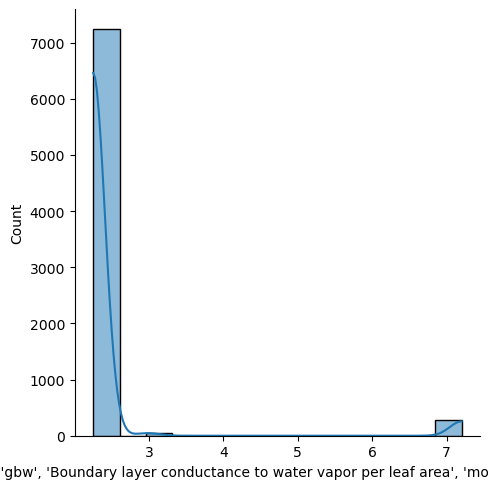

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


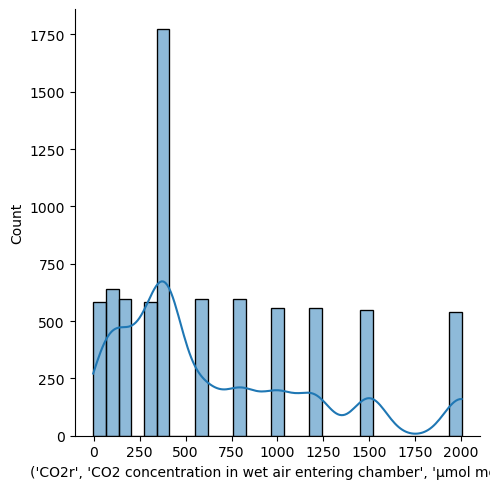

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


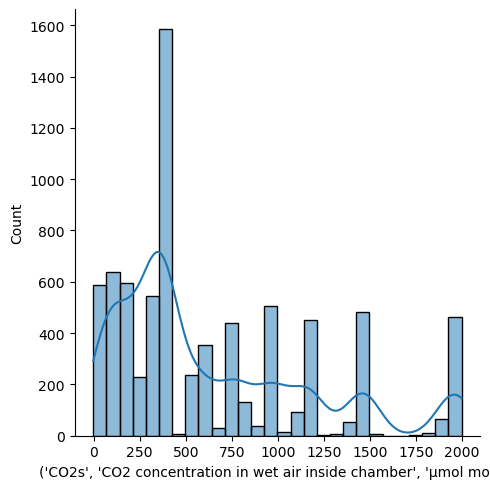

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


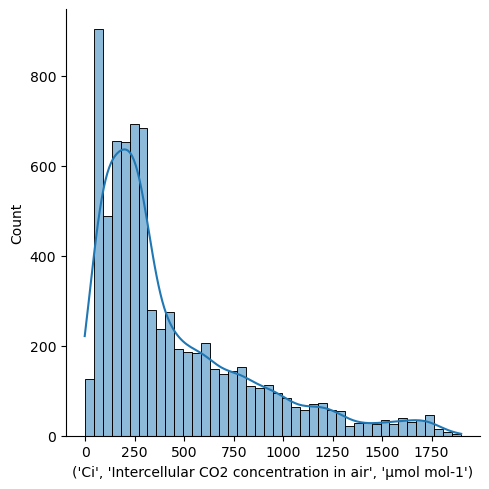

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1')


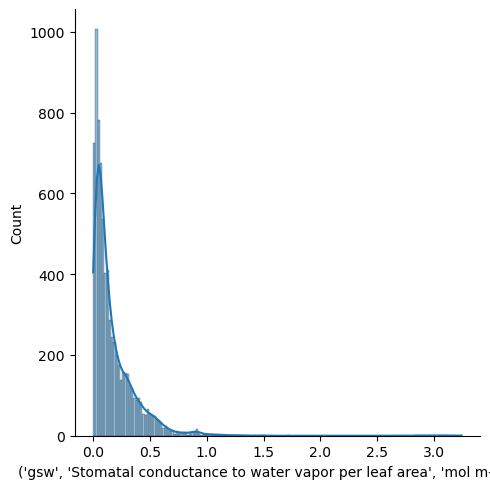

Visualizing ('date', 'Date of observation', 1)


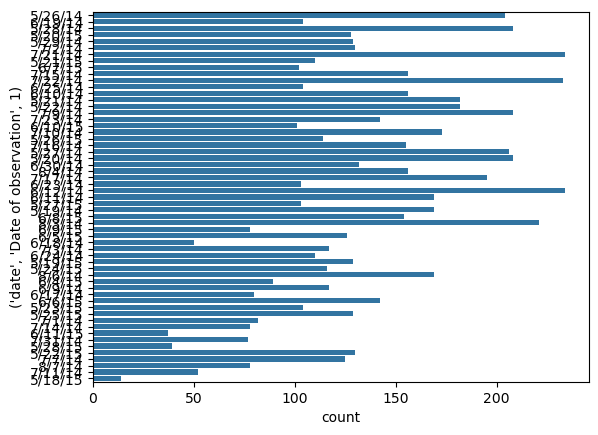

Visualizing ('day', 'Day of observation', 1)


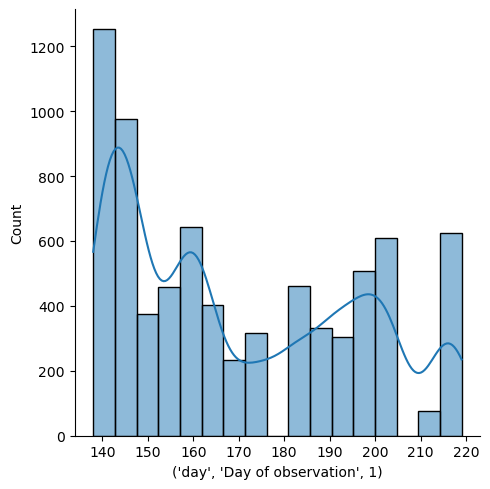

Visualizing ('flow', 'Flow rate of air into chamber', 'μmol s-1')


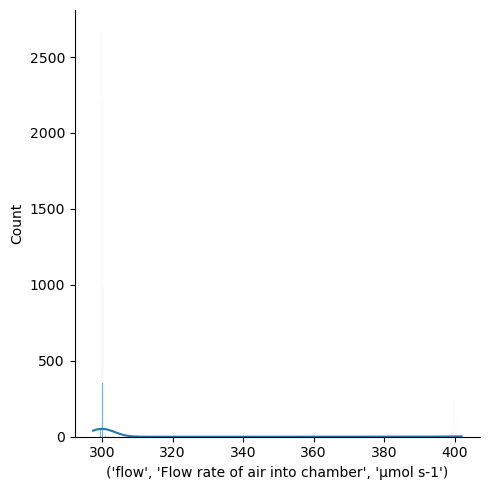

Visualizing ('species', 'Full species name and subspecies if applicable', 1)


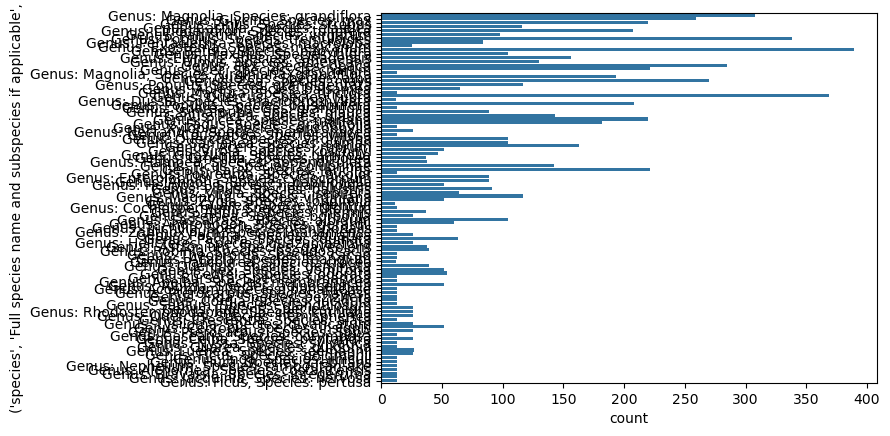

Visualizing ('plantHeight', 'The height of the plant measured', 'cm')


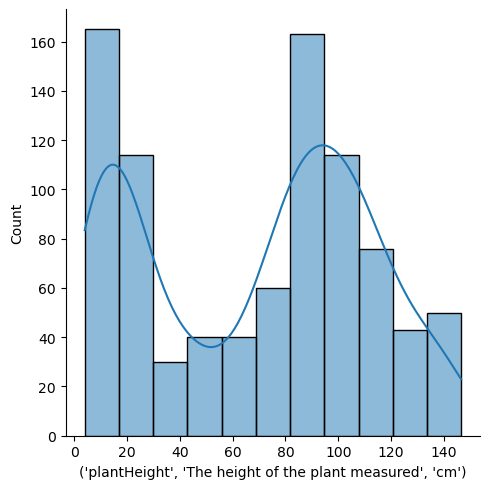

Visualizing ('area', 'Leaf area', 'cm-2')


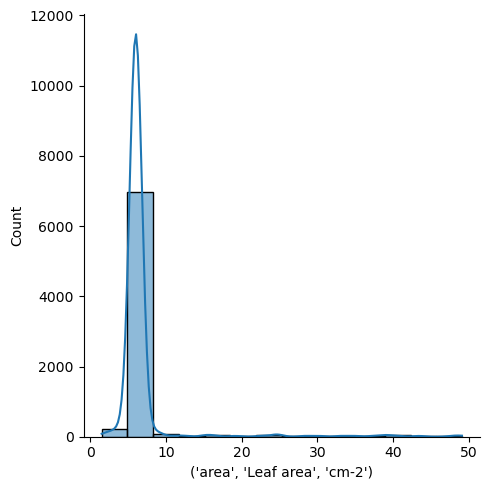

Visualizing ('latitude', 'Latitude coordinate of the site', 'degree')


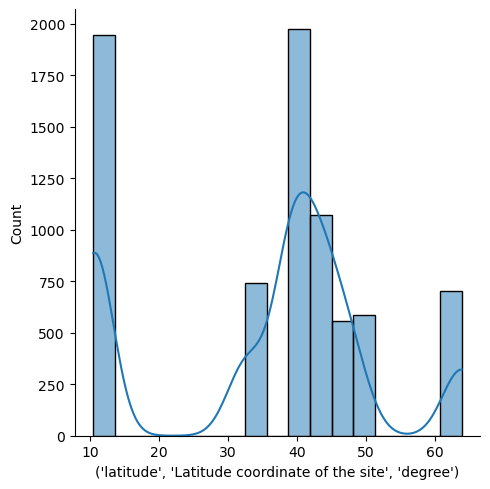

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


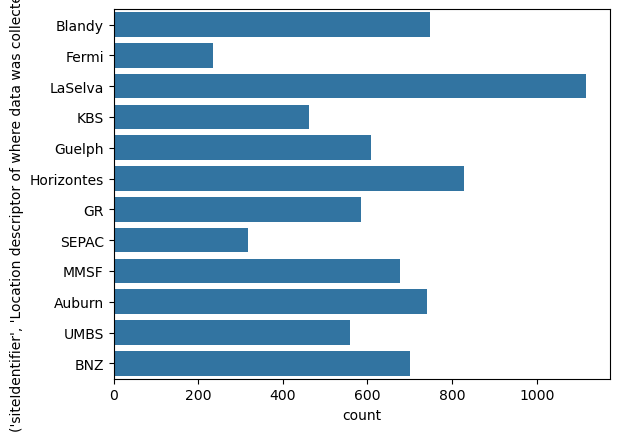

Visualizing ('longitude', 'Longitude coordinate of the site', 'degree')


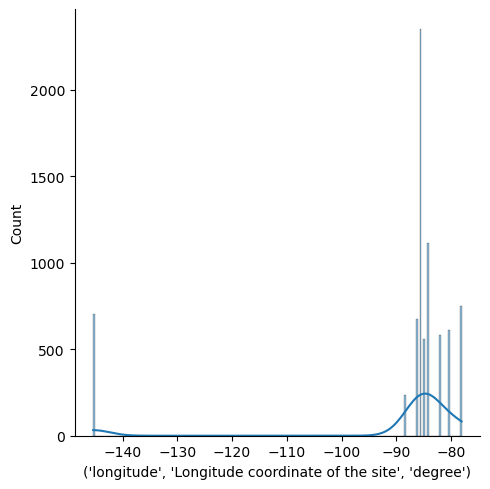

Visualizing ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1)


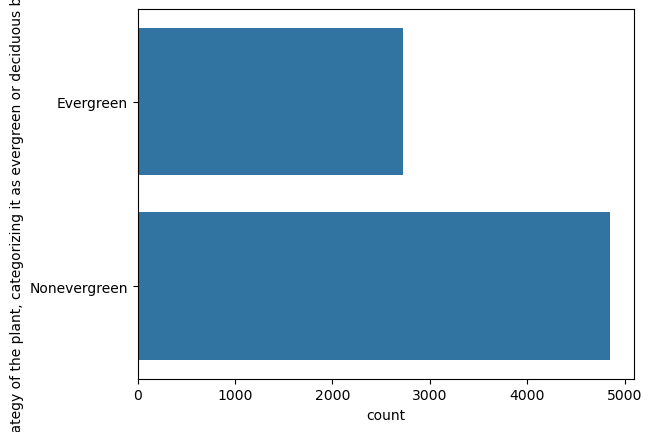

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


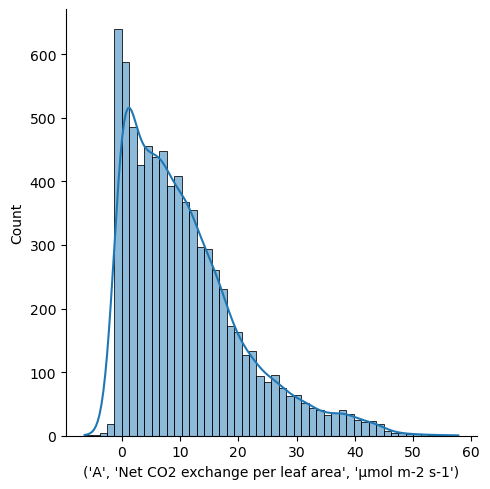

Visualizing ('Patm', 'Atmospheric pressure of the air', 'kPa')


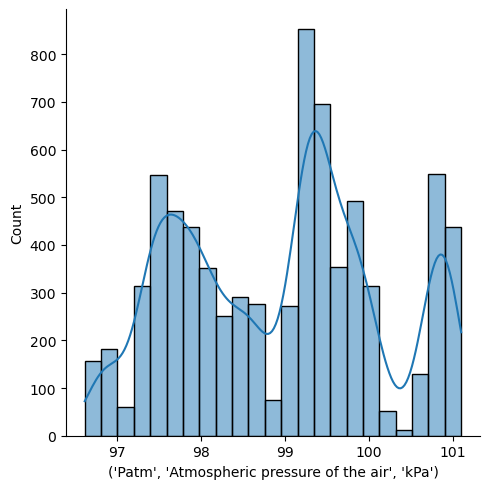

Visualizing ('RHr', 'Relative humidity of air entering the chamber', '%')


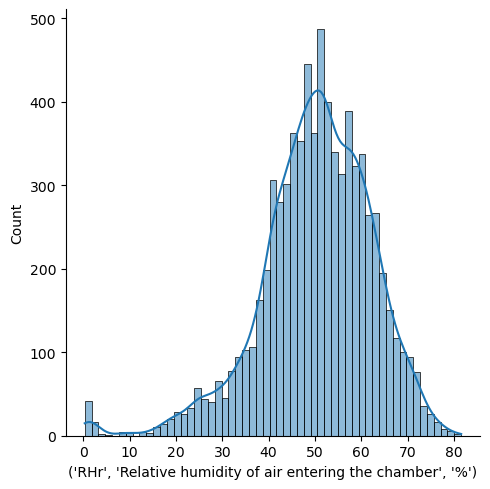

Visualizing ('RHs', 'Relative humidity of air inside the chamber', '%')


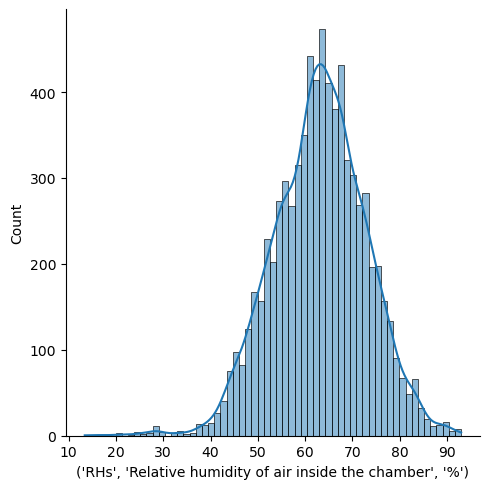

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


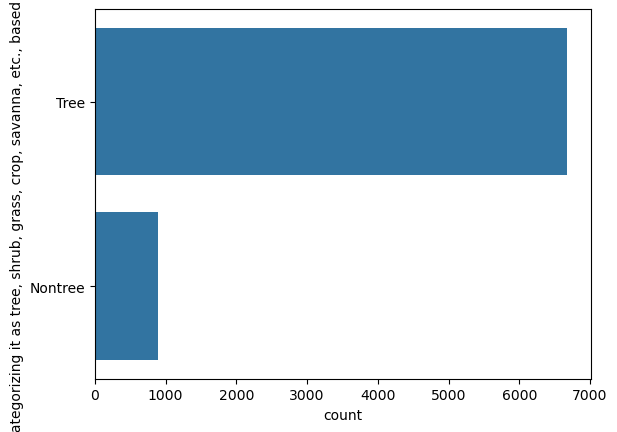

Visualizing ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C')


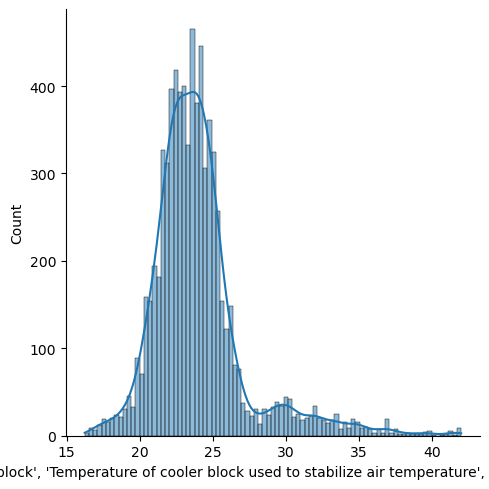

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


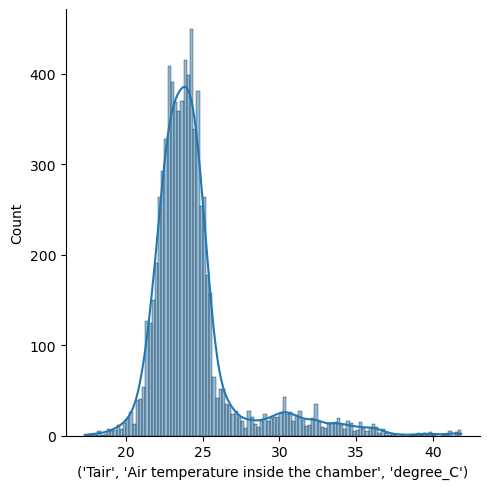

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


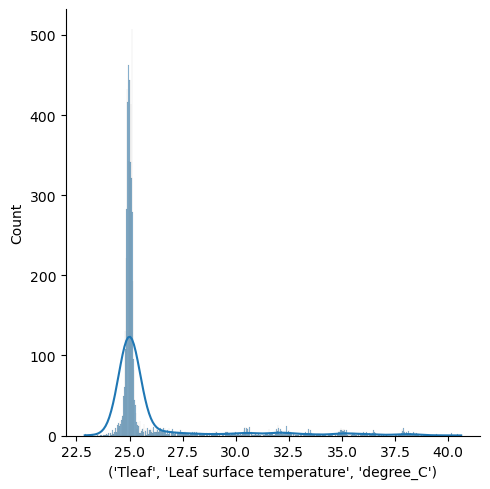

Visualizing ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1')


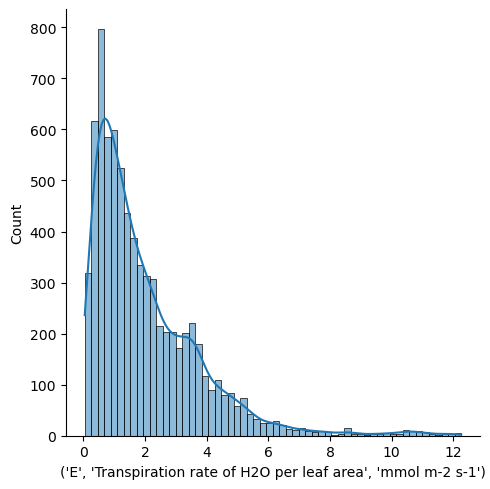

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


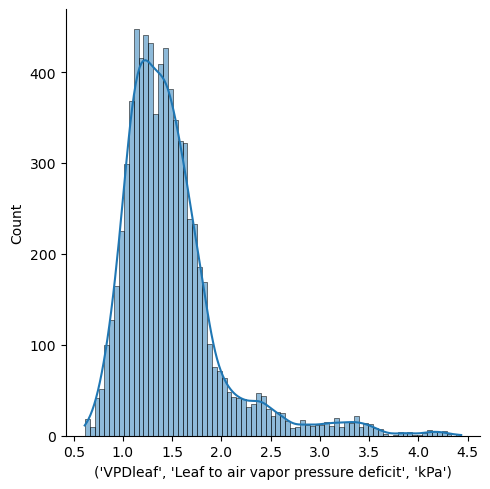

Visualizing ('year', 'Year of observation', 1)


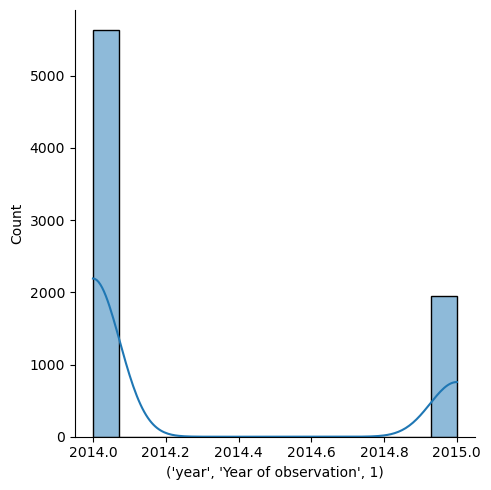

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


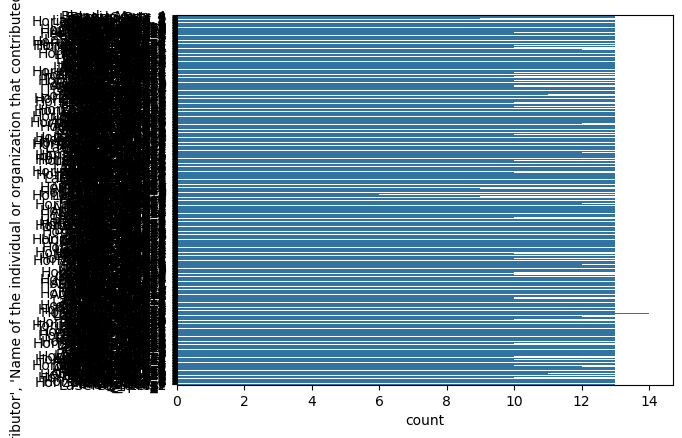

Visualizing ('SampleID', 'Identifier of the measured leaf', 1)


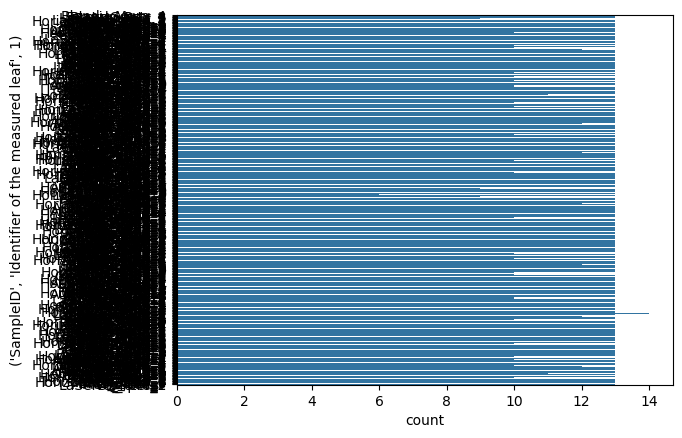

Visualizing ('Record', 'Observation record number', 1)


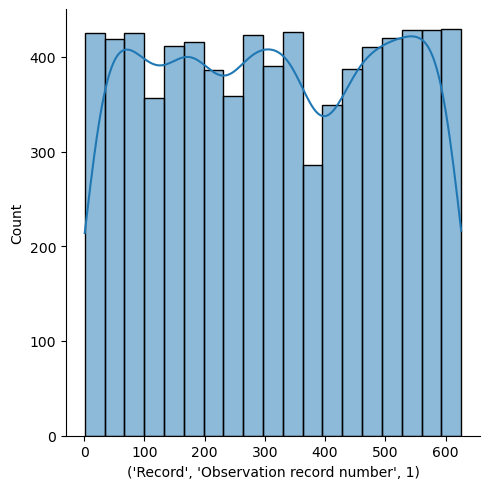

In [29]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control

---
### 4.1. Strings

In [30]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)

In [31]:
# Replace specific values with None
values_to_replace = [-999, -9999, 'none', 'None', np.nan]
filtered_standard_data = filtered_standard_data.replace(values_to_replace, None)

---
### 4.2. Measurement device
There is no measurement device column. This should be found and added to metadata

In [33]:
# add measurement device
device = 'licor 6400'
filtered_standard_data[('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)] = device

---
### 4.3. Season
This should be calculated where possible

---
### 4.4 Plant height

In [34]:
# plant height
filtered_standard_data[('plantHeight', 'The height of the plant measured', 'cm')].unique()

array([None, 13.5, 91.3, 126.8, 100.6, 76.5, 20.6, 77.7, 121.6, 90.5,
       19.4, 40.5, 134.5, 104.4, 93.6, 16.9, 84.0, 8.6, 5.6, 62.0, 6.1,
       64.3, 7.5, 99.9, 103.6, 23.8, 94.6, 43.5, 105.7, 22.5, 71.7, 42.9,
       20.4, 21.7, 88.9, 133.5, 4.0, 102.6, 7.2, 87.6, 8.8, 84.4, 44.0,
       112.8, 81.8, 109.9, 100.9, 22.6, 117.0, 72.2, 82.1, 53.1, 80.2,
       122.2, 136.0, 31.2, 11.4, 137.1, 117.7, 93.4, 146.5, 96.4, 9.1,
       24.4, 142.6, 116.6, 75.9, 67.3, 105.4, 85.0, 114.1, 109.1, 40.2,
       92.4, 66.1], dtype=object)

---
### 4.x. Plant form

In [35]:
filtered_standard_data[('plantForm', 
                        'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 
                        1)].unique()

array(['tree', 'nontree'], dtype=object)

---
### 4.x. Data contributor

In [36]:
# remove extra stuff from the contributor name
filtered_standard_data[('dataContributor',
                        'Name of the individual or organization that contributed to the data',
                        1)] = filtered_standard_data[('dataContributor',
                                                      'Name of the individual or organization that contributed to the data',
                                                      1)].str.split(' ').str[0]

---
### 4.x. Environmental manipulation

In [37]:
filtered_standard_data[('experimentalTreatment', 
                        'Description of any applied sample manipulations', 
                        1)] = filtered_standard_data[('CO2r',
                                                      'CO2 concentration in wet air entering chamber',
                                                      'μmol mol-1')].apply(
    lambda x: 'co2' if pd.notna(x) and (x <= 375 or x >= 425) else 'ambient')

---
### 4.x. Growth environment

In [38]:
# load site info csv
site_info = pd.read_csv(f'../data/input/{filename}/{filename}_site_info.csv', encoding='utf-8')

# normalize 'Short Site Description' in site_info
site_info['Short Site Description'] = site_info['Short Site Description'].str.lower().str.strip()

# create dictionaries for mapping
site_description_map = site_info.set_index('Short Site Description')['Site Description'].to_dict()
growth_environment_map = site_info.set_index('Short Site Description')['growthEnvironment'].to_dict()

# normalize 'dataContributor' in filtered_standard_data before mapping
normalized_data_contributor = filtered_standard_data[('dataContributor', 
                                                      'Name of the individual or organization that contributed to the data', 
                                                      1)].str.lower().str.strip()

# store the original mapped site description separately
mapped_site_description = normalized_data_contributor.map(site_description_map)

# update dataContributor while keeping original values if no match
filtered_standard_data[('dataContributor', 
                        'Name of the individual or organization that contributed to the data', 
                        1)] = mapped_site_description.combine_first(
                            filtered_standard_data[('dataContributor', 
                                                    'Name of the individual or organization that contributed to the data', 
                                                    1)]
)

# map growthEnvironment based on the **original** normalized short site description
filtered_standard_data[('growthEnvironment', 
                        'Description of the plant growth environment', 
                        1)] = normalized_data_contributor.map(growth_environment_map)

In [39]:
filtered_standard_data

standard_variable,gbw,CO2r,CO2s,Ci,gsw,date,day,flow,species,plantHeight,...,E,VPDleaf,year,dataContributor,SampleID,Record,measurementDevice,instrumentType,experimentalTreatment,growthEnvironment
standard_description,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Date of observation,Day of observation,Flow rate of air into chamber,Full species name and subspecies if applicable,The height of the plant measured,...,Transpiration rate of H2O per leaf area,Leaf to air vapor pressure deficit,Year of observation,Name of the individual or organization that contributed to the data,Identifier of the measured leaf,Observation record number,Name of the instrument that collected data,Instrument make & model. Describe any custom modifications in comments,Description of any applied sample manipulations,Description of the plant growth environment
unit,mol m-2 s-1,μmol mol-1,μmol mol-1,μmol mol-1,mol m-2 s-1,1,1,μmol s-1,1,cm,...,mmol m-2 s-1,kPa,1,1,1,1,1,1,1,1
4,2.25,201.25,199.09,132.0,0.0257,5/26/14,146,300.2,"genus: magnolia, species: grandiflora",None,...,0.371,1.42,2014,Blandy Experimental Farm,blandy mgra 4,277,licor 6400,licor 6400,co2,open
5,2.25,99.98,99.82,95.2,0.0273,5/26/14,146,300.2,"genus: magnolia, species: grandiflora",None,...,0.39,1.41,2014,Blandy Experimental Farm,blandy mgra 4,277,licor 6400,licor 6400,co2,open
6,2.25,50.86,51.66,74.2,0.0284,5/26/14,146,300.2,"genus: magnolia, species: grandiflora",None,...,0.401,1.4,2014,Blandy Experimental Farm,blandy mgra 4,277,licor 6400,licor 6400,co2,open
7,2.25,401.1,393.85,202.0,0.0302,5/26/14,146,300.2,"genus: magnolia, species: grandiflora",None,...,0.423,1.38,2014,Blandy Experimental Farm,blandy mgra 4,277,licor 6400,licor 6400,ambient,open
8,2.25,399.46,392.25,206.0,0.0311,5/26/14,146,300.2,"genus: magnolia, species: grandiflora",None,...,0.433,1.38,2014,Blandy Experimental Farm,blandy mgra 4,277,licor 6400,licor 6400,ambient,open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,2.25,799.86,744.58,622.0,0.414,7/15/14,196,300.2,"genus: populus, species: tremuloides",None,...,3.7,0.996,2014,Groundhog River,gr ptre 2,565,licor 6400,licor 6400,co2,open
7573,2.25,997.4,939.77,810.0,0.406,7/15/14,196,300.2,"genus: populus, species: tremuloides",None,...,3.63,0.995,2014,Groundhog River,gr ptre 2,565,licor 6400,licor 6400,co2,open


---
### 4.5. Dates/Times

#### A. If you have a ton of different datetime formats to contend with:
* Create a .csv `../data/temp/datetmes/{filename}_datetime_formatting.csv` with headers `source`, `datetime_formats`, `time_formats`, and `dayfirst`
* Assign a list of datetime formats, time formats, and dayfirst info (whether or not the date starts with a day) in `{filename}_datetime_formatting.csv`
    * Assign these special cases where necessary:
        * decimal_hours (time is in decimal hours), total_minutes (time is in total minutes), date_with_time (date contains time information), range_of_days (date is a range of days, e.g., 1-2 September 2024)
        * add more special case handling in the `funcs.process_datetime()` as needed
* Export filled in `../data/temp/datetmes/{filename}_datetime_formatting.csv` as `../data/temp/datetmes/{filename}_datetime_formatting_01.csv`
<\b>

#### B. If you only have one datetime format, you can just set it here

In [40]:
filtered_standard_data[('date', 'Date of observation', 1)].unique()

array(['5/26/14', '6/19/14', '5/28/14', '5/20/15', '5/29/14', '7/2/14',
       '7/21/14', '5/21/15', '6/7/15', '7/15/14', '7/22/14', '6/25/14',
       '6/10/14', '5/21/14', '5/22/14', '7/9/14', '7/23/14', '6/10/15',
       '7/10/14', '5/26/15', '7/16/14', '5/27/14', '5/20/14', '6/30/14',
       '8/4/14', '7/17/14', '6/23/14', '6/12/14', '6/11/14', '5/27/15',
       '5/19/14', '6/8/15', '8/3/14', '6/9/15', '6/5/15', '6/18/14',
       '7/3/14', '6/24/14', '5/19/15', '5/24/15', '8/6/14', '6/4/15',
       '6/9/14', '6/17/14', '6/6/15', '5/23/15', '5/25/15', '7/1/14',
       '7/14/14', '6/11/15', '7/31/14', '5/28/15', '5/22/15', '7/7/14',
       '8/7/14', '7/11/14', '5/18/15'], dtype=object)

In [41]:
# Extract the date column
date_column = filtered_standard_data[('date', 'Date of observation', 1)]

# Convert the date strings to datetime objects for easier processing
date_column = pd.to_datetime(date_column, format='%m/%d/%y')

# Add the new columns
filtered_standard_data[('year', 'Year of observation', 1)] = date_column.dt.year
filtered_standard_data[('month', 'Month of observation', 1)] = date_column.dt.month
filtered_standard_data[('day', 'Day of observation', 1)] = date_column.dt.day
filtered_standard_data[('time', 'Time of observation', 1)] = None  # No time data available

---
### 4.6. Species names
For this Lin 2015 data, I wanted a visual aid to make sure I was adjusting species names correctly, so I generated a unique ID for each data source and species. That way, I can capture when a data source recorded information for multiple species

In [42]:
# instantiate species checklist
u_species = filtered_standard_data[[('species', 'Full species name and subspecies if applicable', 1),
                       ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
                       ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)]].drop_duplicates()
u_species[('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1)] = None
u_species.columns = u_species.columns.get_level_values(0)
u_species = u_species.rename(columns={'species':'unadjudicatedName'})
u_species = u_species.sort_values(by='unadjudicatedName')
u_species

standard_variable,unadjudicatedName,plantLeaf,plantForm,plantType
242,"genus: abies, species: balsamea",evergreen,tree,None
2188,"genus: acacia, species: mangium",evergreen,tree,None
550,"genus: acer, species: rubrum",nonevergreen,tree,None
180,"genus: acer, species: saccharum",nonevergreen,tree,None
2923,"genus: acosmium, species: panamense",nonevergreen,tree,None
...,...,...,...,...
881,"genus: virola, species: sebifera",evergreen,tree,None
459,"genus: xylopia, species: sericophylla",evergreen,tree,None
1388,"genus: zanthoxylum, species: panamense",evergreen,tree,None
219,"genus: zea, species: mays",nonevergreen,nontree,None


---
### 4.7. Instantiate the species lookup table as `filename_species_lookup.csv`

In [43]:
# add missing columns
u_species['acceptedName'] = None
u_species['nameAuthor'] = None
u_species['nameAuthority'] = None
u_species['nameCategory'] = None
u_species['nameAdjudicator'] = None

# export checklist
u_species.to_csv(f'../data/temp/species/{filename}_species_lookup.csv')

---
### 4.8. Fill in the lookup table information save as `filename_species_lookup_01.csv`
We recommend passing this task on to an expert who can parse through synonymous, mispelled, and misapplied names

In [44]:
# load edited species checklist (species_checklist_01)
species_checklist = pd.read_csv(f'../data/temp/species/{filename}_species_lookup_01.csv', index_col=0)
species_checklist = species_checklist.replace({np.nan: None})
species_checklist

,unadjudicatedName,plantLeaf,plantForm,plantType,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
242,abies balsamea,evergreen,tree,gymnosperm,abies balsamea,None,None,species,None
2188,acacia mangium,evergreen,tree,angiosperm,acacia mangium,None,None,species,None
550,acer rubrum,deciduous,tree,angiosperm,acer rubrum,None,None,species,None
180,acer saccharum,deciduous,tree,angiosperm,acer saccharum,None,None,species,None
2923,acosmium panamense,deciduous,tree,angiosperm,acosmium panamense,None,None,species,None
...,...,...,...,...,...,...,...,...,...
881,virola sebifera,evergreen,tree,angiosperm,virola sebifera,None,None,species,None
459,xylopia sericophylla,evergreen,tree,angiosperm,xylopia sericophylla,None,None,species,None
1388,zanthoxylum panamense,evergreen,tree,angiosperm,zanthoxylum panamense,None,None,species,None
219,zea mays,None,graminoid,angiosperm,zea mays,None,None,species,None


#### 4.8.1. Format the lookup table headers for merging new columns to the data

In [45]:
# make single headers into multi-headers
new_columns = pd.MultiIndex.from_tuples([
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1),  # Matching the multi-header in filtered_standard_data2
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1),
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1),
    ('nameAuthor', 'The author of the accepted species name', 1),
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1),
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1),
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)
])
species_checklist.columns = new_columns

#### 4.8.2. Merge the species data to filtered_standard_data

In [46]:
# merge checklist to filtered_standard_data
merged_df = pd.merge(
    filtered_standard_data,
    species_checklist,
    left_on=[('species', 'Full species name and subspecies if applicable', 1)],
    right_on=[('unadjudicatedName', 'Full species name and subspecies if applicable', 1)],
    how='left'
)

In [47]:
merged_df.columns

MultiIndex([(                  'gbw', ...),
            (                 'CO2r', ...),
            (                 'CO2s', ...),
            (                   'Ci', ...),
            (                  'gsw', ...),
            (                 'date', ...),
            (                  'day', ...),
            (                 'flow', ...),
            (              'species', ...),
            (          'plantHeight', ...),
            (                 'area', ...),
            (             'latitude', ...),
            (       'siteIdentifier', ...),
            (            'longitude', ...),
            (          'plantLeaf_x', ...),
            (                    'A', ...),
            (                 'Patm', ...),
            (                  'RHr', ...),
            (                  'RHs', ...),
            (          'plantForm_x', ...),
            (               'Tblock', ...),
            (                 'Tair', ...),
            (                'Tl

#### 4.8.3. Drop some overlapped columns from the merged dataframe

In [48]:
# specified columns to drop
columns_to_drop = [('plantLeaf_x',
                    'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns',
                    1),
                   ('plantForm_x',
                    'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function',
                    1),
                   ('date', 'Date of observation', 1),
                   ('species', 'Full species name and subspecies if applicable', 1)] #this is replace with unadjudicated and accepted names

# drop the columns and clean up the _y
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
merged_df.columns = pd.MultiIndex.from_tuples([
    (col[0].replace('_y', ''), *col[1:]) for col in merged_df.columns
])
merged_df.head(3)

,gbw,CO2r,CO2s,Ci,gsw,day,flow,plantHeight,area,latitude,...,time,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Day of observation,Flow rate of air into chamber,The height of the plant measured,Leaf area,Latitude coordinate of the site,...,Time of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mol m-2 s-1,μmol mol-1,μmol mol-1,μmol mol-1,mol m-2 s-1,1,μmol s-1,cm,cm-2,degree,...,1,1,1,1,1,1,1,1,1,1
0,2.25,201.25,199.09,132.0,0.0257,26,300.2,None,6.0,39.06,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.25,99.98,99.82,95.2,0.0273,26,300.2,None,6.0,39.06,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.25,50.86,51.66,74.2,0.0284,26,300.2,None,6.0,39.06,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
---
## 5. Unit conversion

In [49]:
# ensure numeric columns are float instead of object dtypes
numeric_cols = []
for col in merged_df.columns:
    try:
        pd.to_numeric(merged_df[col], errors='raise')
        numeric_cols.append(col)
    except ValueError:
        pass  # Skip non-numeric columns

# convert
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype('float32')

# replace NaN with None in numeric columns
merged_df[numeric_cols] = merged_df[numeric_cols].map(lambda x: None if pd.isna(x) else x)

In [50]:
# Create a deep copy of merged_df
merged_df_2 = merged_df.copy(deep=True)
merged_df_2, preconverted_cols, converted_cols = funcs.check_and_convert_units(column_standards, merged_df_2)

Mismatch found: gbw (Boundary layer conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=2250.0, max=7199.999809265137
Converted units and updated header.
Mismatch found: gsw (Stomatal conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=2.691041911020875, max=3240.000009536743
Converted units and updated header.
Mismatch found: plantHeight (The height of the plant measured) - cm to m
Converted data from cm to m: min=0.04, max=1.465
Converted units and updated header.


---
### 5.1. Visualize and confirm unit conversions

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


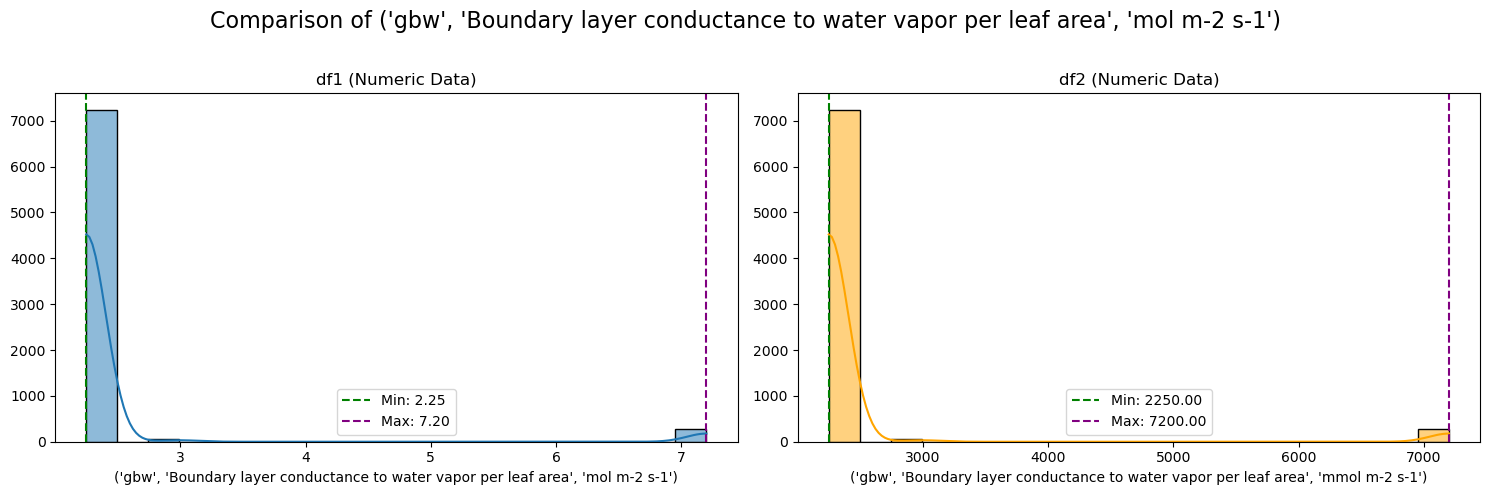

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


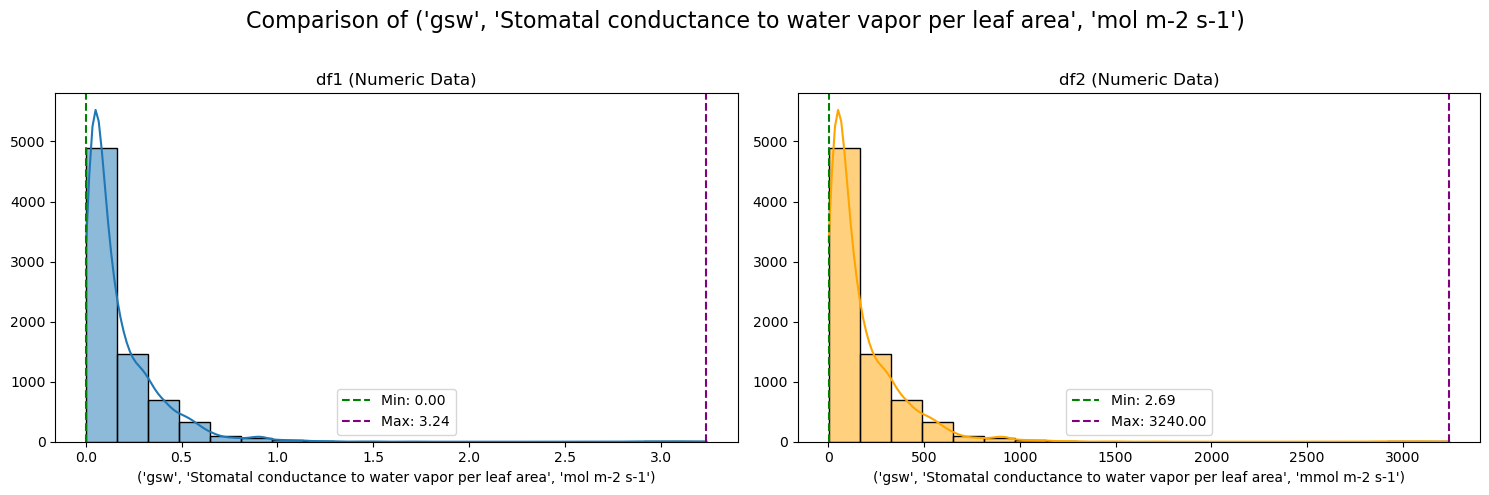

Visualizing ('plantHeight', 'The height of the plant measured', 'cm') and ('plantHeight', 'The height of the plant measured', 'm')


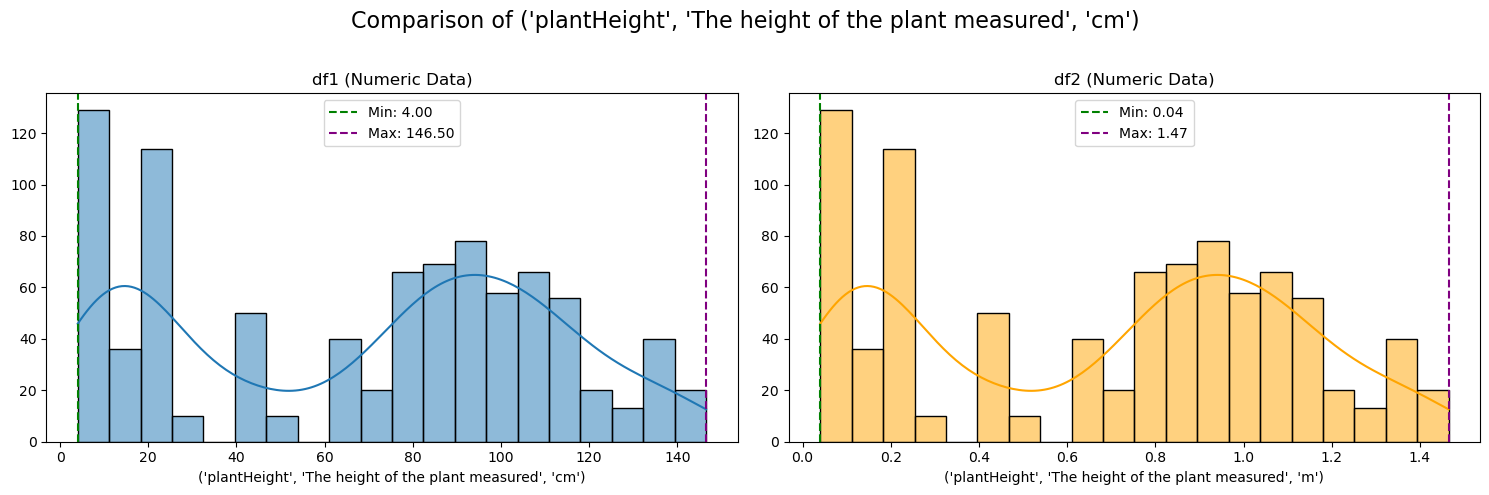

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison(selected_col_1, selected_col_2, col_name):
    """
    Creates a subplot with one row and two columns comparing data from merged_df and filtered_df.
    - Ensures consistent bin sizes across both histograms, while allowing different x-axis ranges.
    
    Parameters:
    selected_col_1 (Series): Data for the left plot (from merged_df).
    selected_col_2 (Series): Data for the right plot (from filtered_df).
    col_name (str): The variable name being compared.
    """
    
    # Drop NaN values only for plotting
    col_1_no_nan = selected_col_1.dropna()
    col_2_no_nan = selected_col_2.dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Comparison of {col_name}', fontsize=16)
    
    # Check if the data is numeric
    if pd.api.types.is_numeric_dtype(col_1_no_nan):
        
        # Determine bin size based on the range of the first dataset
        min1, max1 = col_1_no_nan.min(), col_1_no_nan.max()
        min2, max2 = col_2_no_nan.min(), col_2_no_nan.max()
        
        # Define bin edges
        num_bins = 20
        bin_edges1 = np.linspace(min1, max1, num_bins + 1)
        bin_edges2 = np.linspace(min2, max2, num_bins + 1)

        # Plot numeric data with consistent bin sizes
        sns.histplot(col_1_no_nan, bins=bin_edges1, kde=True, ax=axes[0])
        axes[0].set_title('df1 (Numeric Data)')
        axes[0].axvline(col_1_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_1_no_nan.min():.2f}')
        axes[0].axvline(col_1_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_1_no_nan.max():.2f}')
        axes[0].legend()

        sns.histplot(col_2_no_nan, bins=bin_edges2, kde=True, ax=axes[1], color='orange')
        axes[1].set_title('df2 (Numeric Data)')
        axes[1].axvline(col_2_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_2_no_nan.min():.2f}')
        axes[1].axvline(col_2_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_2_no_nan.max():.2f}')
        axes[1].legend()
    
    else:
        # Plot categorical data if not numeric
        sns.countplot(y=col_1_no_nan, ax=axes[0], color='blue', legend=False)
        axes[0].set_title('df1 (Categorical Data)')
        
        sns.countplot(y=col_2_no_nan, ax=axes[1], color='orange', legend=False)
        axes[1].set_title('df2 (Categorical Data)')
    
    # Remove Y-axis labels
    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Now plot the comparison
for preconv_col, conv_col in zip(preconverted_cols, converted_cols):
    print(f'Visualizing {preconv_col} and {conv_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df[preconv_col].squeeze()
        selected_col_2 = merged_df_2[conv_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, preconv_col)

    except Exception as e:
        print(f'Could not plot...', e)

---
### 5.2. Drop out-of-range values per ESS-Dive leaf-gas-exchange info

In [52]:
oor = pd.read_csv('../data/supp/info_measured_variables.csv')
oor

,variableName,variableUnit,variableDescription,expectedValueRangeMin,expectedValueRangeMax
0,date,YYYY-MM-DD,Date of observation,NaN,NaN
1,time,HH:MM:SS,Time of observation,NaN,NaN
2,record,1,Observation record number,NaN,NaN
3,area,cm-2,Leaf area,NaN,NaN
4,A,µmol m-2 s-1,Net CO₂ exchange per leaf area,-20.0,120.0
5,Amax,µmol m-2 s-1,Highest rate of light and CO₂ saturated A,-20.0,120.0
6,Asat,µmol m-2 s-1,Highest rate of light saturated A at ambient C...,-20.0,120.0
7,Ci,µmol mol-1,Intercellular CO₂ concentration in air,0.0,5000.0
8,CO2r,µmol mol-1,CO₂ concentration in wet air entering chamber,0.0,5000.0
9,CO2s,µmol mol-1,CO₂ concentration in wet air inside chamber,0.0,5000.0


In [53]:
def filter_out_of_range_data(oor, merged_df_2):
    """
    Filters out data in merged_df_2 that falls outside the expected value range specified in oor.
    Also handles potential unit errors for specific variables (e.g., Patm in hPa vs. kPa).
    Special case for RH: Values above 100 are capped at 100 instead of being removed.
    
    Parameters:
    oor (DataFrame): Contains columns variableName, variableUnit, variableDescription, 
                     expectedValueRangeMin, expectedValueRangeMax.
    merged_df_2 (DataFrame): A DataFrame with a 3-row multi-header.
    
    Returns:
    filtered_df (DataFrame): A copy of merged_df_2 with out-of-range values removed or capped.
    filtered_columns (list): List of multi-header column names where out-of-range data was removed or capped.
    """
    
    # Create a copy of merged_df_2 to avoid modifying the original DataFrame
    filtered_df = merged_df_2.copy()

    # List to store multi-header column names where out-of-range data was removed or capped
    filtered_columns = []

    # Iterate over each row in oor
    for _, row in oor.iterrows():
        var_name = row['variableName']
        min_val = row['expectedValueRangeMin']
        max_val = row['expectedValueRangeMax']

        # Check if var_name exists in row 0 of the multi-header
        if var_name in filtered_df.columns.get_level_values(0):
            print(f"Match found for variable: {var_name}")

            # Select the corresponding column(s) in merged_df_2
            selected_cols = filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name]

            try:
                # Attempt to convert to numeric (forcing errors to raise exceptions)
                selected_cols = selected_cols.apply(pd.to_numeric, errors='raise')

                # Store the count of non-NaN values before filtering
                count_before = selected_cols.count().sum()

                # Special handling for Patm: Check for potential hPa values mistakenly recorded as kPa
                if var_name == 'Patm':
                    print(f"Original Patm count: {count_before}")
                    suspect_values = selected_cols[selected_cols < 10]
                    print(f"Suspect Patm values count (less than 10 kPa): {suspect_values.count().sum()}")

                    if not suspect_values.empty:
                        print(f"Suspect values detected for {var_name}. Converting from hPa to kPa...")
                        # Convert suspect values from hPa to kPa by multiplying by 10
                        selected_cols = selected_cols.where(selected_cols >= 10, selected_cols * 10)
                    print(f"Patm count after conversion: {selected_cols.count().sum()}")

                # Special case for RH: Cap values above 100 at 100
                if 'RH' in var_name:
                    over_100_count = (selected_cols > 100).sum().sum()
                    if over_100_count > 0:
                        print(f"Special case for RH: Capping {over_100_count} values over 100 at 100.")
                        selected_cols = selected_cols.where(selected_cols <= 100, 100)

                # Apply min and max filtering using .where()
                if not pd.isna(min_val):
                    selected_cols = selected_cols.where(selected_cols >= min_val)
                if not pd.isna(max_val):
                    selected_cols = selected_cols.where(selected_cols <= max_val)

                # Store the count of non-NaN values after filtering
                count_after = selected_cols.count().sum()

                print(f"{var_name} count before filtering: {count_before}, count after filtering: {count_after}")

                # Check if any data was actually removed or capped
                if count_before > count_after or ('RH' in var_name and over_100_count > 0):
                    # Assign the filtered column back to filtered_df
                    filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name] = selected_cols

                    # Add the multi-header column names to filtered_columns list
                    filtered_columns.extend(selected_cols.columns.tolist())

            except ValueError:
                # Skip columns that cannot be converted to numeric
                print(f"Skipping non-numeric variable: {var_name}")
        else:
            print(f"No match found for variable: {var_name}, skipping.")

    return filtered_df, filtered_columns

In [54]:
filtered_df, oor_cols = filter_out_of_range_data(oor, merged_df_2)
filtered_df

No match found for variable: date, skipping.
Match found for variable: time
time count before filtering: 0, count after filtering: 0
No match found for variable: record, skipping.
Match found for variable: area
area count before filtering: 7524, count after filtering: 7524
Match found for variable: A
A count before filtering: 7572, count after filtering: 7572
No match found for variable: Amax, skipping.
No match found for variable: Asat, skipping.
Match found for variable: Ci
Ci count before filtering: 7572, count after filtering: 7554
Match found for variable: CO2r
CO2r count before filtering: 7572, count after filtering: 7554
Match found for variable: CO2s
CO2s count before filtering: 7572, count after filtering: 7554
No match found for variable: dCO2, skipping.
No match found for variable: dH2O, skipping.
Match found for variable: E
E count before filtering: 7572, count after filtering: 7572
Match found for variable: flow
flow count before filtering: 7572, count after filtering: 757

,gbw,CO2r,CO2s,Ci,gsw,day,flow,plantHeight,area,latitude,...,time,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Day of observation,Flow rate of air into chamber,The height of the plant measured,Leaf area,Latitude coordinate of the site,...,Time of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mmol m-2 s-1,μmol mol-1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,μmol s-1,m,cm-2,degree,...,1,1,1,1,1,1,1,1,1,1
0,2250.0,201.250000,199.089996,132.000000,25.699999,26.0,300.200012,NaN,6.0,39.060001,...,None,None,None,None,None,None,None,None,None,None
1,2250.0,99.980003,99.820000,95.199997,27.300000,26.0,300.200012,NaN,6.0,39.060001,...,None,None,None,None,None,None,None,None,None,None
2,2250.0,50.860001,51.660000,74.199997,28.400000,26.0,300.200012,NaN,6.0,39.060001,...,None,None,None,None,None,None,None,None,None,None
3,2250.0,401.100006,393.850006,202.000000,30.200001,26.0,300.200012,NaN,6.0,39.060001,...,None,None,None,None,None,None,None,None,None,None
4,2250.0,399.459991,392.250000,206.000000,31.099999,26.0,300.200012,NaN,6.0,39.060001,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7568,2250.0,799.859985,744.580017,622.000000,414.000005,15.0,300.200012,NaN,6.0,48.220001,...,None,None,None,None,None,None,None,None,None,None
7569,2250.0,997.400024,939.770020,810.000000,405.999988,15.0,300.200012,NaN,6.0,48.220001,...,None,None,None,None,None,None,None,None,None,None


Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


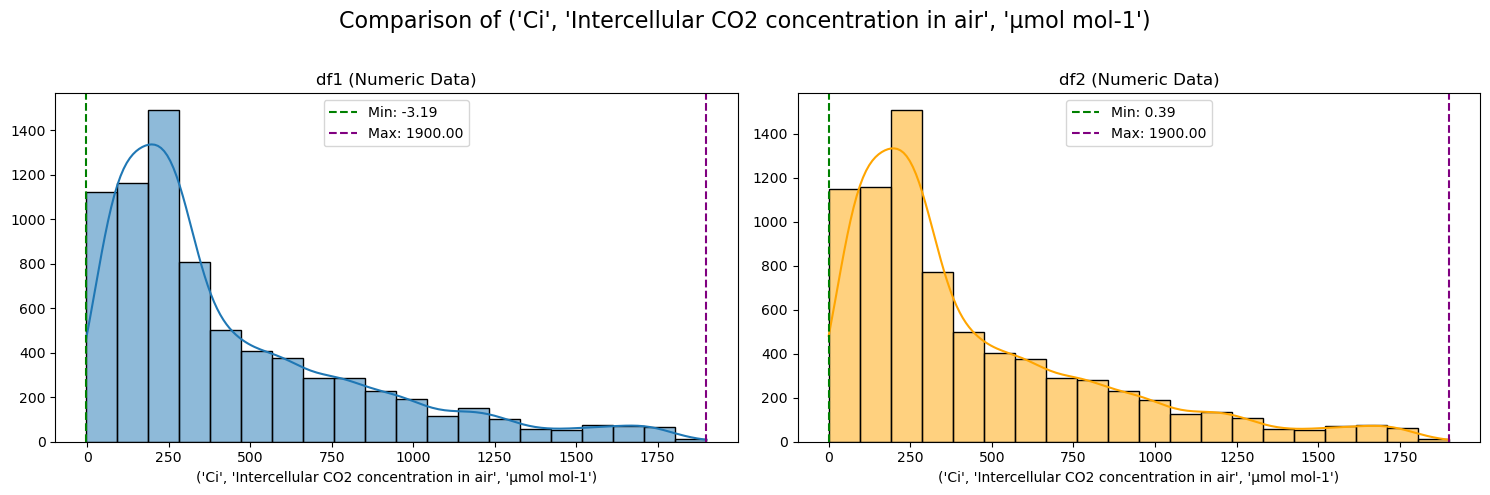

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


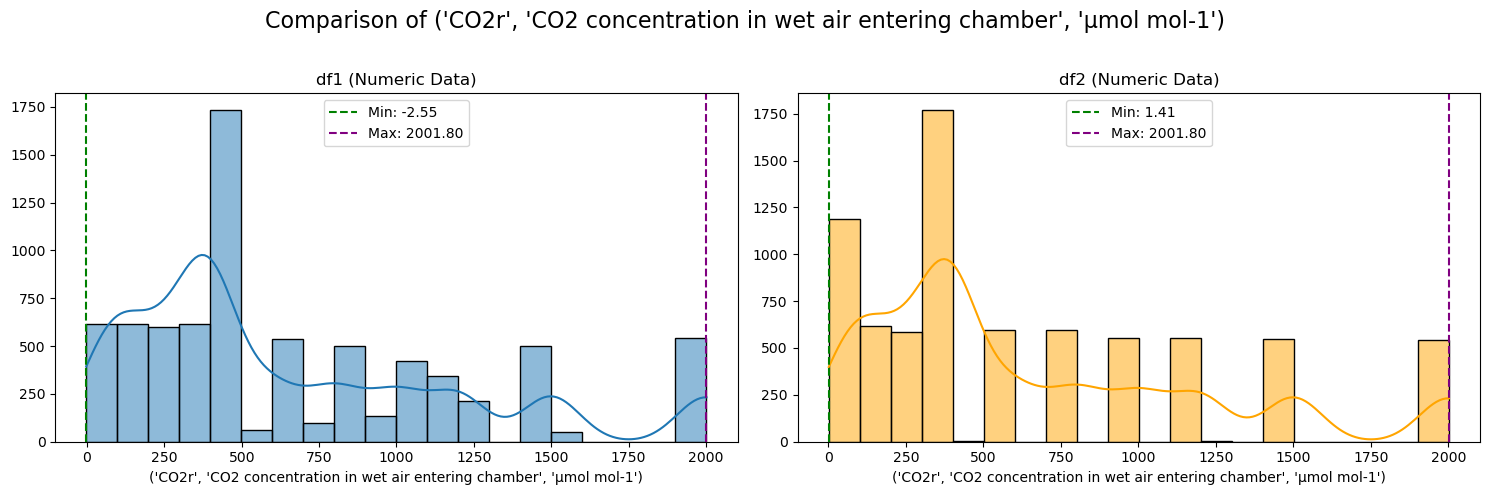

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


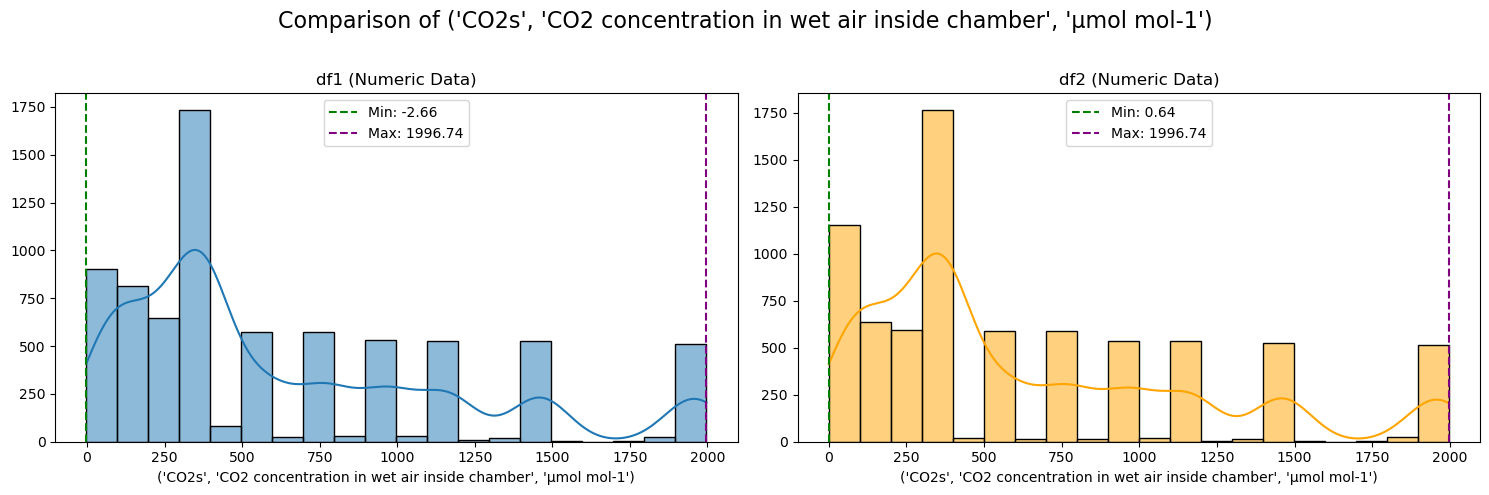

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


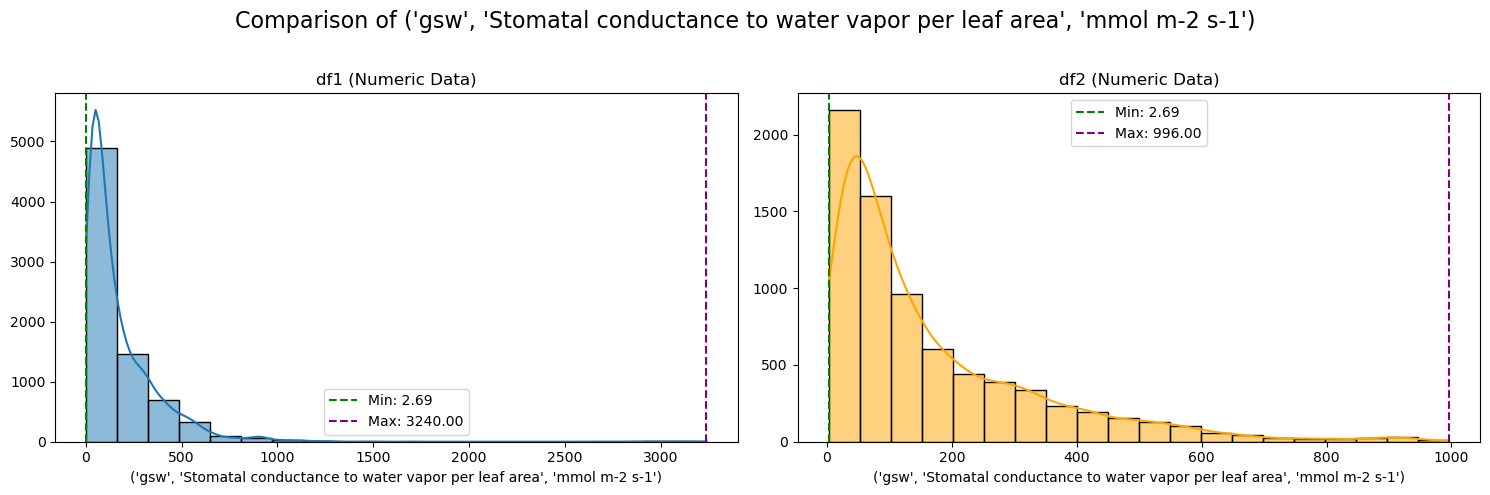

In [55]:
# Now plot the comparison
for oor_col in oor_cols:
    print(f'Visualizing {oor_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df_2[oor_col].squeeze()
        selected_col_2 = filtered_df[oor_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, oor_col)

    except Exception as e:
        print(f'Could not plot...', e)

In [56]:
# # export
# filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')

In [57]:
# # Create the profiling report
# df = filtered_df.copy()
# df.columns = df.columns.get_level_values(0)
# profile = ProfileReport(df, title=f"{filename} Quality Controlled Profiling Report")

# # Save the profile report as HTML
# output_directory = f'../data/input/{filename}'
# report_html_path = os.path.join(output_directory, f"{filename}_qc_report.html")
# profile.to_file(report_html_path)
# print(f"Profiling report saved as {report_html_path}")

In [ ]:
id_col = ('SampleID', 'Identifier of the measured leaf', 1)
a_col  = ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')
ci_col = ('Ci', 'Intercellular CO2 concentration in air','μmol mol-1')

# make a new df with only those three columns
df3 = filtered_df.loc[:, [id_col, a_col, ci_col]]
df3.columns = ['SampleID','Record','A','Ci']
df3

,SampleID,Record,A,Ci
0,blandy mgra 4,277.0,1.010000,132.000000
1,blandy mgra 4,277.0,0.040900,95.199997
2,blandy mgra 4,277.0,-0.421000,74.199997
3,blandy mgra 4,277.0,3.460000,202.000000
4,blandy mgra 4,277.0,3.440000,206.000000
...,...,...,...,...
7568,gr ptre 2,565.0,24.900000,622.000000
7569,gr ptre 2,565.0,25.400000,810.000000
7570,gr ptre 2,565.0,26.700001,1000.000000
7571,gr ptre 2,565.0,27.299999,1290.000000


In [60]:
# drop SampleIDs with one point
counts = df3.groupby('SampleID').size()
good = counts[counts >= 5].index
df_filtered = df3[df3['SampleID'].isin(good)]
df_filtered

,SampleID,A,Ci
0,blandy mgra 4,1.010000,132.000000
1,blandy mgra 4,0.040900,95.199997
2,blandy mgra 4,-0.421000,74.199997
3,blandy mgra 4,3.460000,202.000000
4,blandy mgra 4,3.440000,206.000000
...,...,...,...
7568,gr ptre 2,24.900000,622.000000
7569,gr ptre 2,25.400000,810.000000
7570,gr ptre 2,26.700001,1000.000000
7571,gr ptre 2,27.299999,1290.000000


In [62]:
# for sid, grp in df_filtered.groupby('SampleID'):
#     plt.figure(figsize=(6,4))
#     plt.plot(grp['Ci'], grp['A'], 'o')
#     plt.title(f"A-Ci: Sample {sid}")
#     plt.xlabel("Ci (µmol mol⁻¹)")
#     plt.ylabel("A (µmol m⁻² s⁻¹)")
#     plt.show()

In [66]:
filtered_df = filtered_df.drop(columns=[('Record', 'Observation record number', 1)])
filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')